In [28]:
import numpy as np
import csv
import matplotlib.pyplot as plt
import itertools

# Prepare data

## Load data

We first load student data from csv file and remove any entries that has `Target` = "Enrolled". This is because given that a student is enrolled doesn't say whether he/she will graduate or drop out in the future, so excluding these samples will remove the noise and give the model the chance to learn the patterns better.

In [2]:
FEATURE_FIELDS = {
    'Marital status',
    'Application mode',
    'Application order',
    'Course',
    'Daytime/evening attendance\t',
    'Previous qualification',
    'Previous qualification (grade)',
    'Nacionality',
    "Mother's qualification",
    "Father's qualification",
    "Mother's occupation",
    "Father's occupation",
    'Admission grade',
    'Displaced',
    'Educational special needs',
    'Debtor',
    'Tuition fees up to date',
    'Gender',
    'Scholarship holder',
    'Age at enrollment',
    'International',
    'Curricular units 1st sem (credited)',
    'Curricular units 1st sem (enrolled)',
    'Curricular units 1st sem (evaluations)',
    'Curricular units 1st sem (approved)',
    'Curricular units 1st sem (grade)',
    'Curricular units 1st sem (without evaluations)',
    'Curricular units 2nd sem (credited)',
    'Curricular units 2nd sem (enrolled)',
    'Curricular units 2nd sem (evaluations)',
    'Curricular units 2nd sem (approved)',
    'Curricular units 2nd sem (grade)',
    'Curricular units 2nd sem (without evaluations)',
    'Unemployment rate',
    'Inflation rate',
    'GDP',
}

def load_student_data(path_data='data/student-dropout/data.csv', feature_fields=FEATURE_FIELDS):
    """
    Load dataset and remove 'Enrolled' target
    """

    data = []
    with open(path_data, encoding='utf-8-sig') as f_data:
        for datum in csv.DictReader(f_data, delimiter=';'):
            remove = False

            for field in list(datum.keys()):
                if field in feature_fields and datum[field]:
                    datum[field] = float(datum[field])
                if field == 'Target':
                    if datum[field] == 'Enrolled':
                        remove = True
                    elif datum[field] == 'Dropout':
                        datum[field] = -1.
                    else: # 'Graduated'
                        datum[field] = 1.
            
            if not remove:
                data.append(datum)
    return data


In [3]:
student_data = load_student_data()

print('Loaded', len(student_data), 'student records')

Loaded 3630 student records


## Feature transformation

We will write some techniques to preprocess data before feeding them into our model. Explicitly represent the data in the way we want the model to learn will help improve the performance. These includes:

- `standard` standardizes a given feature to have a standard Gaussian distribution 
- `raw` returns the input value as is, without any transformation (for unordered discrete features)
- `one_hot` represents input as binary vector (for ordered discrete features)

In [4]:
def std_vals(data, f):
    """ Compute average and standard deviation of feature f"""

    vals = [entry[f] for entry in data]
    avg = sum(vals)/len(vals)
    dev = [(entry[f] - avg)**2 for entry in data]
    sd = (sum(dev)/len(vals))**0.5

    return (avg, sd)

def standard(v, std):
    """ Standardize a value v given the average and standard deviation """

    return [(v-std[0])/std[1]]

def raw(x):
    """ No transformation """

    return [x]

def one_hot(v, entries):
    """ One-hot encoding """

    vec = len(entries)*[0]
    vec[entries.index(v)] = 1
    return vec


## Preprocess data

We now assign and apply the preprocess techniques above to their according features

In [5]:
feature_transforms = [
    ('Marital status', one_hot),
    ('Application mode', one_hot),
    ('Application order', raw),
    ('Course', one_hot),
    ('Daytime/evening attendance\t', raw),
    ('Previous qualification', one_hot),
    ('Previous qualification (grade)', standard),
    ('Nacionality', one_hot),
    ("Mother's qualification", one_hot),
    ("Father's qualification", one_hot),
    ("Mother's occupation", one_hot),
    ("Father's occupation", one_hot),
    ('Admission grade', standard),
    ('Displaced', raw),
    ('Educational special needs', raw),
    ('Debtor', raw),
    ('Tuition fees up to date', raw),
    ('Gender', raw),
    ('Scholarship holder', raw),
    ('Age at enrollment', raw),
    ('International', raw),
    ('Curricular units 1st sem (credited)', raw),
    ('Curricular units 1st sem (enrolled)', raw),
    ('Curricular units 1st sem (evaluations)', raw),
    ('Curricular units 1st sem (approved)', raw),
    ('Curricular units 1st sem (grade)', raw),
    ('Curricular units 1st sem (without evaluations)', raw),
    ('Curricular units 2nd sem (credited)', raw),
    ('Curricular units 2nd sem (enrolled)', raw),
    ('Curricular units 2nd sem (evaluations)', raw),
    ('Curricular units 2nd sem (approved)', raw),
    ('Curricular units 2nd sem (grade)', raw),
    ('Curricular units 2nd sem (without evaluations)', raw),
    ('Unemployment rate', standard),
    ('Inflation rate', standard),
    ('GDP', standard),
]

In [6]:
def preprocess(data, features, verbose=True):
    """ Preprocess data according to features """

    features = [('Target', raw)] + features
    std = {f:std_vals(data, f) \
           for (f, phi) in features if phi==standard}
    entries = {f : sorted(set([entry[f] for entry in data])) \
               for (f, phi) in features if phi==one_hot}
    if verbose:
        print('Mean and Std:', std)
        print('Entries in one_hot field:', entries)
    
    findex = 0
    # Print the meaning of features
    for (f, phi) in features[1:]: # skip 'Target'
        if phi == standard:
            if verbose: print(findex, f, 'std')
            findex += 1
        elif phi == one_hot:
            for entry in entries[f]:
                if verbose: print(findex, f, entry, 'one_hot')
                findex += 1
        else:
            if verbose: print(findex, f, 'raw')
            findex += 1

    # Transform data
    vals = []
    for entry in data:
        phis = []
        for (f, phi) in features:
            if phi == standard:
                phis.extend(phi(entry[f], std[f]))
            elif phi == one_hot:
                phis.extend(phi(entry[f], entries[f]))
            else:
                phis.extend(phi(entry[f]))
        vals.append(np.array([phis])) # phis of shape (1,D)

    data_labels = np.vstack(vals)
    np.random.seed(0)
    np.random.shuffle(data_labels)
    return data_labels[:, 1:], data_labels[:, 0:1]


In [7]:
X, y = preprocess(student_data, feature_transforms, verbose=False)
print('\nData shape:', X.shape)
print('Labels shape:', y.shape)


Data shape: (3630, 238)
Labels shape: (3630, 1)


## Train/Test split

Before getting into the model, we have to reserve a portion of the dataset for testing purpose later. This is to make sure the performance we get from training can generalize to the scenario where the model has never seen the data before.

We have two functions, `random_split` and `stratified_split`. They are used to split a dataset into training and testing sets.

- The `random_split` function randomly splits the dataset into training and testing sets, where the proportion of data in the testing set is determined by the `test_pct` parameter.

- The `stratified_split` function performs a similar split, but ensures that the distribution of the target variable is maintained in both the training and testing sets.

In [8]:
def random_split(data, labels, test_pct=0.2, seed=None):
    """ Randomly split data and labels into train and test sets """

    if seed and isinstance(seed, int):
        np.random.seed(seed)

    n, d = data.shape
    idxs = np.random.permutation(n)
    split_pt = int((1 - test_pct) * n)
    train_idxs, test_idxs = idxs[:split_pt], idxs[split_pt:]
    X_train, y_train = data[train_idxs, :], labels[train_idxs, :]
    X_test, y_test = data[test_idxs, :], labels[test_idxs, :]
    
    return X_train, y_train, X_test, y_test

In [9]:
def stratified_split(data, labels, test_pct=0.2, seed=None):
    """ Split data and labels into train and test sets, preserving label ratios """

    if seed and isinstance(seed, int):
        np.random.seed(seed)

    unique_labels, label_counts = np.unique(labels, return_counts=True)
    test_label_counts = (label_counts * test_pct).astype(int)
    train_label_counts = label_counts - test_label_counts
    train_idxs, test_idxs = [], []

    for label, train_count, test_count in zip(unique_labels, train_label_counts, test_label_counts):
        label_idxs = np.where(labels == label)[0] # return an array of indexes
        permuted_idxs = np.random.permutation(label_idxs)
        train_idxs.extend(permuted_idxs[:train_count])
        test_idxs.extend(permuted_idxs[train_count:])

    X_train, y_train = data[train_idxs], labels[train_idxs]
    X_test, y_test = data[test_idxs], labels[test_idxs]

    return X_train, y_train, X_test, y_test


We then visualize the distribution of the target variable. The resulting plots show the distribution of the target variable in both sets, highlighting any differences or imbalances between the two.

In [10]:
# X_train, y_train, X_test, y_test = random_split(X, y)
X_train, y_train, X_test, y_test = stratified_split(X, y)

Train labels:
  -1.0 appears 1137 times - 39.14%
  1.0 appears 1768 times - 60.86%
Test labels:
  -1.0 appears 284 times - 39.17%
  1.0 appears 441 times - 60.83%


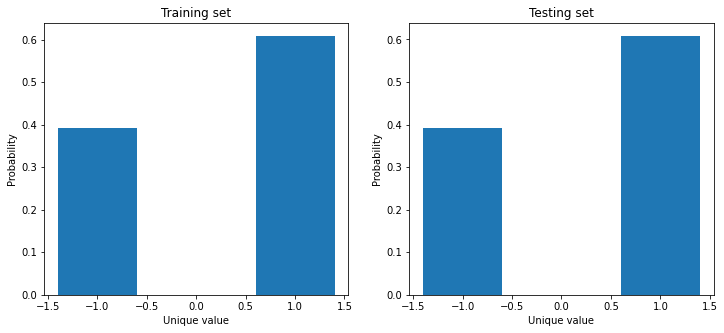

In [11]:
def value_counts(y):
    vals, cnts = np.unique(y, return_counts=True)
    probs = cnts / np.sum(cnts)
    for value, count, prob in zip(vals, cnts, probs):
        print(f"  {value} appears {count} times - {prob*100:.2f}%")
    return vals, cnts, probs

print('Train labels:')
train_vals, train_cnts, train_probs = value_counts(y_train)
print('Test labels:')
test_vals, test_cnts, test_probs = value_counts(y_test)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
ax1.bar(train_vals, train_probs)
ax1.set_title("Training set")
ax1.set_xlabel("Unique value")
ax1.set_ylabel("Probability")

ax2.bar(test_vals, test_probs)
ax2.set_title("Testing set")
ax2.set_xlabel("Unique value")
ax2.set_ylabel("Probability")

plt.show()

# Metrics

To evaluate the performance of a classification model, we will use `accuracy`, `precision`, `recall`, and `f1` scores. These metrics are calculated based on the predicted and true labels of a set of data points. 

We also applied `Laplace smoothing` to avoid division by zero errors. Addtionally, it ensures that if an event has never happened before, then it won't get a probability of zero.

Finally, we have `Confusion matrix` as a way to visualize how well our model performs

In [24]:
# Calculate accuracy
def accuracy(y_pred, y_true):
    return np.sum(y_true == y_pred) / len(y_true)

# Calculate precision
def precision(y_pred, y_true):
    class_labels = np.unique(y_true)  # Get unique class labels
    k = len(class_labels)
    precision_scores = []
    for label in class_labels:
        TP = np.sum(np.logical_and(y_pred == label, y_true == label))
        FP = np.sum(np.logical_and(y_pred == label, y_true != label))
        precision = (TP + 1e-8) / (TP + FP + 1e-8 * k)
        precision_scores.append(precision)
    average_precision = np.mean(precision_scores)
    return average_precision

# Calculate recall
def recall(y_pred, y_true):
    class_labels = np.unique(y_true)  # Get unique class labels
    k = len(class_labels)
    recall_scores = []
    for label in class_labels:
        TP = np.sum(np.logical_and(y_pred == label, y_true == label))
        FN = np.sum(np.logical_and(y_pred != label, y_true == label))
        recall = (TP + 1e-8) / (TP + FN + 1e-8 * k)
        recall_scores.append(recall)
    average_recall = np.mean(recall_scores)
    return average_recall

# Calculate F1 score
def f1(y_pred, y_true):
    class_labels = np.unique(y_true)  # Get unique class labels
    k = len(class_labels)
    f1_scores = []
    for label in class_labels:
        TP = np.sum(np.logical_and(y_pred == label, y_true == label))
        FP = np.sum(np.logical_and(y_pred == label, y_true != label))
        FN = np.sum(np.logical_and(y_pred != label, y_true == label))
        precision = (TP + 1e-8) / (TP + FP + 1e-8 * k)
        recall = (TP + 1e-8) / (TP + FN + 1e-8 * k)
        f1 = 2 * (precision * recall) / (precision + recall)
        f1_scores.append(f1)
    average_f1 = np.mean(f1_scores)
    return average_f1

# Confusion matrix
def confusion_matrix(y_pred, y_true):
    class_labels = np.unique(y_true)  # Get unique class labels
    TPs, FPs, FNs, TNs = [], [], [], []
    for label in class_labels:
        TP = np.sum(np.logical_and(y_pred == label, y_true == label))
        FP = np.sum(np.logical_and(y_pred == label, y_true != label))
        FN = np.sum(np.logical_and(y_pred != label, y_true == label))
        TN = np.sum(np.logical_and(y_pred != label, y_true != label))
        TPs.append(TP)
        FPs.append(FP)
        FNs.append(FN)
        TNs.append(TN)
    return np.array([[int(np.mean(TPs)), int(np.mean(FPs))], [int(np.mean(FNs)), int(np.mean(TNs))]])

# Plot confusion matrix
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
  
    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# Models


We will implement 3 algorithms for classification: `decision trees`, `random forests`, and `bagging`.

## Decision Tree

In [13]:
class DTNode:
    """ Decision Tree Node """
    N_THRESHOLD = 4                 # don't split if node has fewer examples than this
    H_THRESHOLD = .01               # don't split if node has entropy less than this
    H_REDUCTION_THRESHOLD = .001    # don't split if it doesn't reduce H by this
    MAX_DEPTH = 10                  # maximum depth of the tree

    index = 0
    tree_depth = 0                  # current depth of the whole tree

    def __init__(self, data=None, config=None, depth=0):
        """ Create a node in the decision tree. """
        
        self.config = config
        if config != None:
            self.N_THRESHOLD = config[0]
            self.H_THRESHOLD = config[1]
            self.H_REDUCTION_THRESHOLD = config[2]
            self.MAX_DEPTH = config[3]

        DTNode.index += 1
        self.index = DTNode.index           # unique number for each node
        self.data = data                    # data at the node
        self.prob = None                    # probability of positive label (label = 1) for the data at the node
        self.depth = depth                  # depth of the node in the tree
        if self.depth > DTNode.tree_depth:
            DTNode.tree_depth = self.depth

        if data is not None:
            self.n = float(data.shape[0])          # number of data points at the node
            self.indices = range(data.shape[1]-1)  # indices of features (used for splitting)
            self.set_h()                           # compute entropy of the node

        self.splits = {}    # splits for each feature (key = feature index, value = C{List} of thresholds)
        self.fi = None      # feature index of the best split
        self.th = None      # threshold of the best split
        self.lc = None      # left child node
        self.rc = None      # right child node
        self.parent = None  # parent node

    def set_h(self):
        """ Set the entropy of the node, assumes labels are 1, -1 """

        b = .001
        npos = np.sum(self.data[:, -1] == 1)  # count labels = 1
        prob = (npos + b) / (self.n + b + b)
        self.prob = prob
        self.H = -prob*np.log(prob) - (1-prob)*np.log(1-prob)

    def build_tree(self):
        """ Build the tree recursively """

        # don't split if entropy is low, or if there are few examples, or if we're too deep
        if self.H < self.H_THRESHOLD or self.n < self.N_THRESHOLD or self.depth >= self.MAX_DEPTH:
            return

        # find best split (with max information gain)
        (i, th, (h, lc, rc)) = self.argmax([(i, th, self.split_eval(i, th)) \
                                                for i in self.indices       \
                                                for th in self.get_splits(i)], 
                                           lambda x: self.H - x[2][0])

        # don't split if it doesn't reduce entropy enough
        if self.H - h < self.H_REDUCTION_THRESHOLD:
            return
        
        self.fi = i
        self.th = th
        self.lc = lc
        self.rc = rc
        self.lc.parent = self
        self.rc.parent = self
        
        # recursively build children
        self.lc.build_tree()
        self.rc.build_tree()

    def get_splits(self, i):
        """ Find the best splitting point for data at node along feature at index i """

        if i not in self.splits:
            self.splits[i] = np.sort(np.unique(self.data[:,i]), axis=None)
        return self.splits[i]

    def split_eval(self, i, th):
        """ Evaluate weighted average entropy of splitting feature at index i by threshold th """

        lc = DTNode(self.data[self.data[:, i] < th], config=self.config, depth=self.depth+1)
        rc = DTNode(self.data[self.data[:, i] >= th], config=self.config, depth=self.depth+1)
        pl = lc.n / self.n
        pr = 1.0 - pl
        avgH = pl*lc.H + pr*rc.H

        return avgH, lc, rc
    
    def classify(self, x):
        """ Classify a single example """

        # return probability of positive label if leaf node
        if self.fi == None:
            return self.prob            
        if x[self.fi] < self.th:
            return self.lc.classify(x)
        else:
            return self.rc.classify(x)

    def display(self, depth=0, max_display_depth=3):
        """ Display the tree """

        if depth > max_display_depth:
            print(depth*'  ', 'Depth >', max_display_depth)
            return
        if self.fi is None:
            print('\033[32m', end="")
            print(depth*'  ', f'[L={depth}]', "%.2f"%self.prob, '[', 'n=', "%.0f"%self.n, ']')
            print('\033[0m', end="")            
            return
        print(depth*'  ', f'[N={depth}]', 'fi', self.fi, '< th=', "%.5f"%self.th, '[', 'n=', "%.0f"%self.n, ']')
        self.lc.display(depth+1, max_display_depth)
        self.rc.display(depth+1, max_display_depth)

    @staticmethod
    def argmax(l, f):
        """
        @param l: C{List} of items
        @param f: C{Procedure} that maps an item into a numeric score
        @returns: the element of C{l} that has the highest score
        """
        vals = [f(x) for x in l]
        return l[vals.index(max(vals))]


In [14]:
class DecisionTree:
    """ Decision Tree Classifier """

    def fit(self, X, Y, config=None):
        D = np.hstack([X,Y])
        self.root = DTNode(D, config=config)
        self.root.build_tree()
        return self.root
        
    def predict(self, X):
        pred = np.array([np.apply_along_axis(self.root.classify, 1, X)]).T - 0.5
        pred[pred >= 0] = 1
        pred[pred < 0] = -1
        return pred
    
    def display(self, depth=0, max_depth=3):
        self.root.display(depth, max_depth)


## Bagging

In [15]:
class Bagging:
    """ Bagging (Booststrap Aggregation) Classifier """
    
    def __init__(self, num_trees=5):
        self.ntrees = num_trees
        self.trees = []
        
    def fit(self, X, Y, config=None):
        for i in range(self.ntrees):
            idxs = np.random.choice(len(X), size=len(X), replace=True)
            X_train = X[idxs, :]
            Y_train = Y[idxs, :]
            dt = DecisionTree()
            dt.fit(X_train, Y_train, config)
            self.trees.append(dt)
            
    def predict(self, X):
        preds = []
        if len(self.trees) == 0: return None
        for dt in self.trees:
            pred = dt.predict(X)
            preds.append(pred)
        preds = np.hstack(preds)
        return np.sign(preds.mean(axis=1, keepdims=True))


## Random Forest

In [16]:
class RandomForest:
    """ Random Forest Classifier """
    
    def __init__(self, num_trees=5, num_features=None):
        self.ntrees = num_trees
        self.nfeats = num_features
        self.trees = []
        self.feats = []
    
    def fit(self, X, Y, config=None):
        for i in range(self.ntrees):
            idxs = np.random.choice(len(X), size=len(X), replace=True)
            if self.nfeats is not None:
                features = np.random.choice(X.shape[1], size=self.nfeats, replace=False)
                X_train = X[idxs][:, features]
                self.feats.append(features)
            else:
                X_train = X[idxs]
            Y_train = Y[idxs]
            dt = DecisionTree()
            dt.fit(X_train, Y_train, config)
            self.trees.append(dt)
    
    def predict(self, X):
        preds = []
        if len(self.trees) == 0:
            return None
        for i in range(len(self.trees)):
            dt = self.trees[i]
            if self.nfeats is not None:
                features = self.feats[i]
                X_test = X[:, features]
            else:
                X_test = X
                
            pred = dt.predict(X_test)
            preds.append(pred)
        preds = np.hstack(preds)
        return np.sign(np.mean(preds, axis=1, keepdims=True))

# Training

We will use cross-validation to evaluate the performance of the models. Finally, we evaluate how well our models perform on unseen data from the test set we set aside earlier. Here are the functions we will use.

In [27]:
def evaluate(model_class, X_train, Y_train, X_test, Y_test, max_depth=5, verbose=True, config=None, args=None, plot_confusion=False):
    if args:
        model = model_class(*args)
    else:
        model = model_class()
    model.fit(X_train, Y_train, config)
    pred_test = model.predict(X_test)
    acc_s = accuracy(pred_test, Y_test)
    prec_s = precision(pred_test, Y_test)
    rec_s = recall(pred_test, Y_test)
    f1_s = f1(pred_test, Y_test)
    cm = confusion_matrix(pred_test, Y_test)

    if verbose:
        print(f'  Accuracy  : {acc_s:.5f}')
        print(f'  Precision : {prec_s:.5f}')
        print(f'  Recall    : {rec_s:.5f}')
        print(f'  F1        : {f1_s:.5f}')
        if isinstance(model, DecisionTree): 
            model.display(max_depth=max_depth)

    if plot_confusion:
        plot_confusion_matrix(cm, ['G', 'D'])
    return acc_s, prec_s, rec_s, f1_s

In [18]:
def cross_validate(data, labels, k=10, model='DecisionTree', verbose=True, config=None, args=None):
    if model == 'Bagging':
        model_class = Bagging
    elif model == 'RandomForest':
        model_class = RandomForest
    else:
        model_class = DecisionTree
    indices = np.random.permutation(data.shape[0])
    X = data[indices,:]
    Y = labels[indices,:]
    s_data = np.array_split(X, k, axis=0)
    s_labels = np.array_split(Y, k, axis=0)
    acc_s = 0.
    prec_s = 0.
    rec_s = 0.
    f1_s = 0.
    for i in range(k):
        X_train = np.concatenate(s_data[:i] + s_data[i+1:], axis=0)
        Y_train = np.concatenate(s_labels[:i] + s_labels[i+1:], axis=0)
        X_test = np.array(s_data[i])
        Y_test = np.array(s_labels[i])
        if verbose == "first_tree":
            if i == 0:
                acc, prec, rec, f1 = evaluate(model_class, X_train, Y_train, X_test, Y_test, verbose=True, config=config, args=args)
            else:
                acc, prec, rec, f1 = evaluate(model_class, X_train, Y_train, X_test, Y_test, verbose=False, config=config, args=args)
        elif verbose == True:
            print('Round',i+1)
            acc, prec, rec, f1 = evaluate(model_class, X_train, Y_train, X_test, Y_test, verbose=True, config=config, args=args)
        else:
            acc, prec, rec, f1 = evaluate(model_class, X_train, Y_train, X_test, Y_test, verbose=False, config=config, args=args)
        acc_s += acc
        prec_s += prec
        rec_s += rec
        f1_s += f1
    print('\nCROSS VALIDATION RESULTS:')
    print(f'- Avg. Accuracy  : {acc_s/k:.5f}')
    print(f'- Avg. Precision : {prec_s/k:.5f}')
    print(f'- Avg. Recall    : {rec_s/k:.5f}')
    print(f'- Avg. F1        : {f1_s/k:.5f}')
    return acc_s/k, prec_s/k, rec_s/k, f1_s/k


## Training and fine-tuning

During the training phase, the model is fitted using the training data (`X_train` and `y_train`). After that, we evaluate the performance of the model using the validation data (`X_val` and `y_val`) and employ cross-validation to fine-tune hyperparameters. 

This method helps to estimate how well the model will perform on new, unseen data, and enables us to make any necessary adjustments to the model. By using the validation dataset, we can also avoid overfitting and ensure that the model generalizes well to new data.

In [19]:
X_dev, y_dev, X_val, y_val = stratified_split(X_train, y_train)

In [20]:
evaluate(DecisionTree, X_dev, y_dev, X_val, y_val, config=[4, .01, .001, 4], verbose=False)
# evaluate(RandomForest, X_dev, y_dev, X_val, y_val, args=[5, 2], config=[4, .01, .001, 7])
# evaluate(Bagging, X_dev, y_dev, X_val, y_val, args=[5], config=[4, .01, .001, 5])

(0.906896551724138, 0.9185991735757446, 0.8881331818878793, 0.8990185583736106)

In [21]:
# cross_validate(X_train, y_train, k=5, verbose=True, config=[4, .01, .001, 3])
cross_validate(X_train, y_train, model='RandomForest', k=5, verbose=True, args=[10, 200])
# cross_validate(X_train, y_train, model='Bagging', k=5, verbose=True, args=[7])

Round 1
  Accuracy  : 0.89157
  Precision : 0.90512
  Recall    : 0.87479
  F1        : 0.88875
Round 2
  Accuracy  : 0.89329
  Precision : 0.92983
  Recall    : 0.88089
  F1        : 0.89962
Round 3
  Accuracy  : 0.89845
  Precision : 0.93227
  Recall    : 0.88233
  F1        : 0.90387
Round 4
  Accuracy  : 0.90189
  Precision : 0.92620
  Recall    : 0.88768
  F1        : 0.90257
Round 5
  Accuracy  : 0.88296
  Precision : 0.90707
  Recall    : 0.86201
  F1        : 0.88150

CROSS VALIDATION RESULTS:
- Avg. Accuracy  : 0.89363
- Avg. Precision : 0.92010
- Avg. Recall    : 0.87754
- Avg. F1        : 0.89526


(0.893631669535284, 0.9200972242796869, 0.8775418748821421, 0.8952623607815428)

# Plotting

Now we will plot some figures to see how the performance of models varies based on the hyperparameters.

## For decision tree

Max depth 1 done
Max depth 2 done
Max depth 3 done
Max depth 4 done
Max depth 5 done
Max depth 6 done
Max depth 7 done
Max depth 8 done
Max depth 9 done
Max depth 10 done


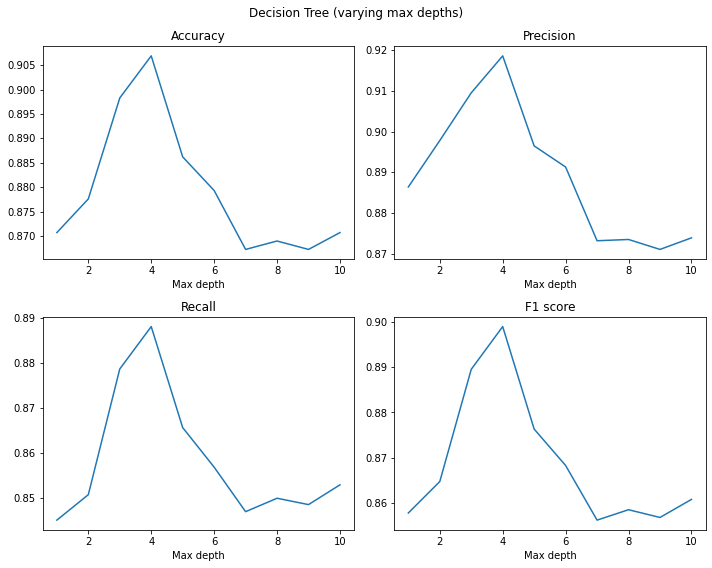

In [34]:
max_depths = np.arange(1, 11)
accs = []
precs = []
recs = []
f1s = []

for max_d in max_depths:
    acc, prec, rec, f1_ = evaluate(DecisionTree, X_dev, y_dev, X_val, y_val, config=[4, .01, .001, max_d], verbose=False)
    accs.append(acc)
    precs.append(prec)
    recs.append(rec)
    f1s.append(f1_)
    print(f'Max depth {max_d} done')

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 8))
fig.suptitle("Decision Tree (varying max depths)")

ax1.plot(max_depths, accs)
ax1.set_title("Accuracy")
ax1.set_xlabel("Max depth")

ax2.plot(max_depths, precs)
ax2.set_title("Precision")
ax2.set_xlabel("Max depth")

ax3.plot(max_depths, recs)
ax3.set_title("Recall")
ax3.set_xlabel("Max depth")

ax4.plot(max_depths, f1s)
ax4.set_title("F1 score")
ax4.set_xlabel("Max depth")

plt.tight_layout()  # Optional: Adjust the spacing between subplots

plt.savefig('images/dt_max_depths.png')
plt.show()

## For random forest

Varying the number of features with the number of trees fixed

N. feats: 1 done
N. feats: 2 done
N. feats: 3 done
N. feats: 4 done
N. feats: 5 done
N. feats: 7 done
N. feats: 10 done
N. feats: 13 done
N. feats: 17 done
N. feats: 23 done
N. feats: 31 done
N. feats: 42 done
N. feats: 56 done
N. feats: 75 done
N. feats: 100 done
N. feats: 133 done
N. feats: 178 done
N. feats: 237 done


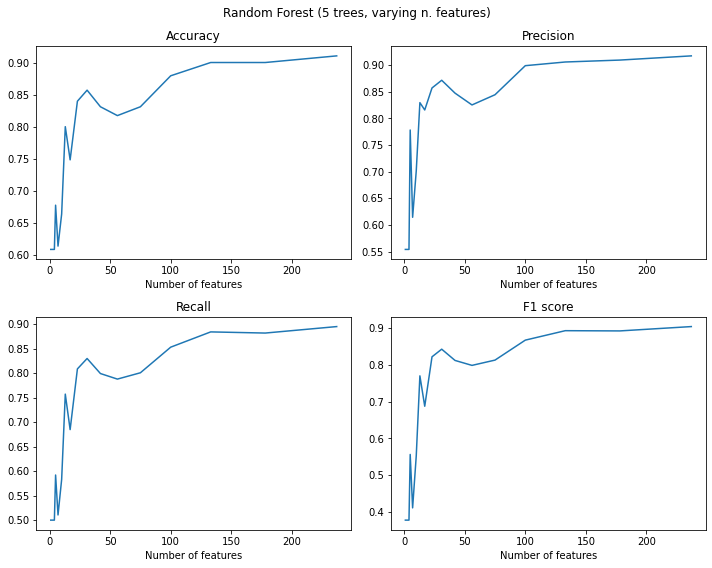

In [35]:
n_feats_list = np.unique(np.logspace(np.log10(1), np.log10(238), num=20, dtype=int))
accs = []
precs = []
recs = []
f1s = []

for n_feats in n_feats_list:
    acc, prec, rec, f1_ = evaluate(RandomForest, X_dev, y_dev, X_val, y_val, args=[5, n_feats], verbose=False)
    accs.append(acc)
    precs.append(prec)
    recs.append(rec)
    f1s.append(f1_)
    print(f'N. feats: {n_feats} done')

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 8))
fig.suptitle("Random Forest (5 trees, varying n. features)")

ax1.plot(n_feats_list, accs)
ax1.set_title("Accuracy")
ax1.set_xlabel("Number of features")

ax2.plot(n_feats_list, precs)
ax2.set_title("Precision")
ax2.set_xlabel("Number of features")

ax3.plot(n_feats_list, recs)
ax3.set_title("Recall")
ax3.set_xlabel("Number of features")

ax4.plot(n_feats_list, f1s)
ax4.set_title("F1 score")
ax4.set_xlabel("Number of features")

plt.tight_layout()

plt.savefig('images/rf_n_feats.png')
plt.show()

Varying the number of trees while the number of features fixed

N. trees: 1 done
N. trees: 2 done
N. trees: 3 done
N. trees: 4 done
N. trees: 6 done
N. trees: 9 done
N. trees: 14 done
N. trees: 20 done
N. trees: 29 done


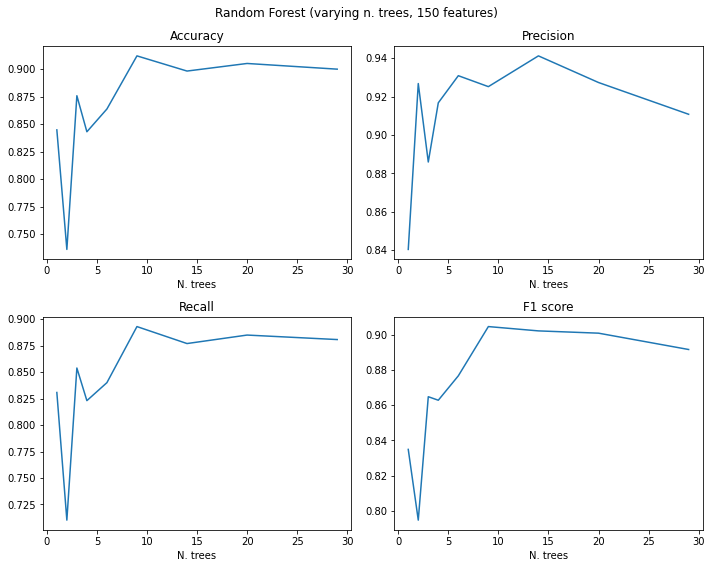

In [36]:
n_trees_list = np.unique(np.logspace(np.log10(1), np.log10(30), num=10, dtype=int))
accs = []
precs = []
recs = []
f1s = []

for n_trees in n_trees_list:
    acc, prec, rec, f1_ = evaluate(RandomForest, X_dev, y_dev, X_val, y_val, args=[n_trees, 150], verbose=False)
    accs.append(acc)
    precs.append(prec)
    recs.append(rec)
    f1s.append(f1_)
    print(f'N. trees: {n_trees} done')

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 8))
fig.suptitle("Random Forest (varying n. trees, 150 features)")

ax1.plot(n_trees_list, accs)
ax1.set_title("Accuracy")
ax1.set_xlabel("N. trees")

ax2.plot(n_trees_list, precs)
ax2.set_title("Precision")
ax2.set_xlabel("N. trees")

ax3.plot(n_trees_list, recs)
ax3.set_title("Recall")
ax3.set_xlabel("N. trees")

ax4.plot(n_trees_list, f1s)
ax4.set_title("F1 score")
ax4.set_xlabel("N. trees")

plt.tight_layout()

plt.savefig('images/rf_n_trees.png')
plt.show()

N. trees: 1 done
N. trees: 2 done
N. trees: 3 done
N. trees: 5 done
N. trees: 7 done
N. trees: 10 done
N. trees: 14 done
N. trees: 20 done


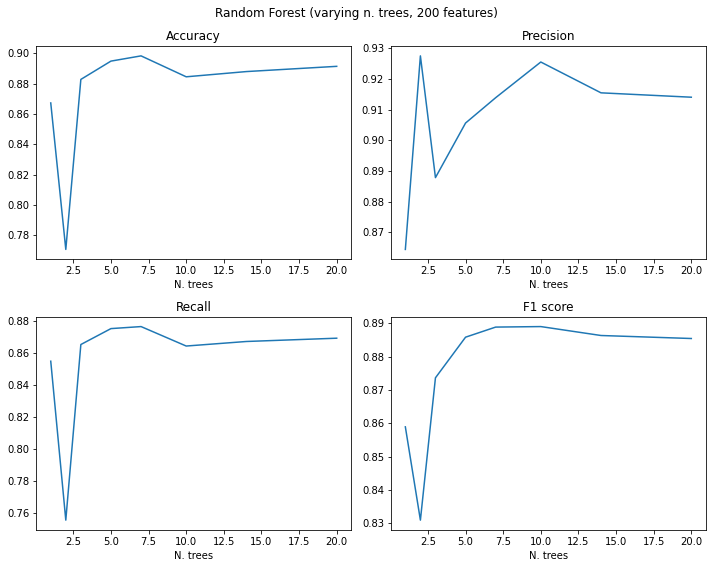

In [38]:
n_trees_list = np.unique(np.logspace(np.log10(1), np.log10(20), num=10, dtype=int))
accs = []
precs = []
recs = []
f1s = []

for n_trees in n_trees_list:
    acc, prec, rec, f1_ = evaluate(RandomForest, X_dev, y_dev, X_val, y_val, args=[n_trees, 200], verbose=False)
    accs.append(acc)
    precs.append(prec)
    recs.append(rec)
    f1s.append(f1_)
    print(f'N. trees: {n_trees} done')

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 8))
fig.suptitle("Random Forest (varying n. trees, 200 features)")

ax1.plot(n_trees_list, accs)
ax1.set_title("Accuracy")
ax1.set_xlabel("N. trees")

ax2.plot(n_trees_list, precs)
ax2.set_title("Precision")
ax2.set_xlabel("N. trees")

ax3.plot(n_trees_list, recs)
ax3.set_title("Recall")
ax3.set_xlabel("N. trees")

ax4.plot(n_trees_list, f1s)
ax4.set_title("F1 score")
ax4.set_xlabel("N. trees")

plt.tight_layout()

plt.savefig('images/rf_n_trees2.png')
plt.show()

## For bagging

N. trees: 1 done
N. trees: 2 done
N. trees: 3 done
N. trees: 5 done
N. trees: 7 done
N. trees: 10 done
N. trees: 14 done
N. trees: 20 done


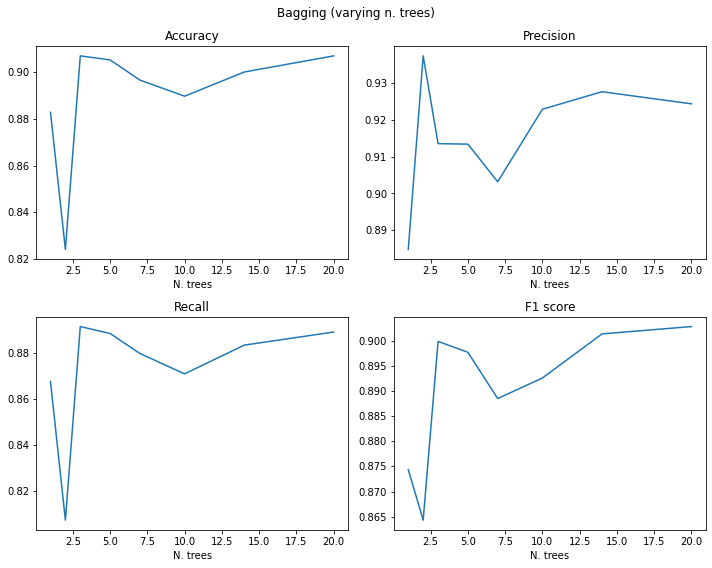

In [37]:
n_trees_list = np.unique(np.logspace(np.log10(1), np.log10(20), num=10, dtype=int))
accs = []
precs = []
recs = []
f1s = []

for n_trees in n_trees_list:
    acc, prec, rec, f1_ = evaluate(Bagging, X_dev, y_dev, X_val, y_val, args=[n_trees], verbose=False)
    accs.append(acc)
    precs.append(prec)
    recs.append(rec)
    f1s.append(f1_)
    print(f'N. trees: {n_trees} done')

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 8))
fig.suptitle("Bagging (varying n. trees)")

ax1.plot(n_trees_list, accs)
ax1.set_title("Accuracy")
ax1.set_xlabel("N. trees")

ax2.plot(n_trees_list, precs)
ax2.set_title("Precision")
ax2.set_xlabel("N. trees")

ax3.plot(n_trees_list, recs)
ax3.set_title("Recall")
ax3.set_xlabel("N. trees")

ax4.plot(n_trees_list, f1s)
ax4.set_title("F1 score")
ax4.set_xlabel("N. trees")

plt.tight_layout()  # Optional: Adjust the spacing between subplots

plt.savefig('images/bag_n_trees.png')
plt.show()

# Insights

You might have noticed that when we plot our Decision Tree. When the maximum depth is just one, the model reached unusually high accuracy (87%) and similarly for the other metrics. Let's investiage this further.

In [31]:
_ = evaluate(DecisionTree, X_dev, y_dev, X_val, y_val, config=[4, .01, .001, 1])

  Accuracy  : 0.87069
  Precision : 0.88637
  Recall    : 0.84502
  F1        : 0.85774
 [N=0] fi 232 < th= 4.00000 [ n= 2325 ]
   [L=1] 0.09 [ n= 748 ]
   [L=1] 0.85 [ n= 1577 ]


The above means the first node with split at feature 232 on value 4.0 and before splitting it has a total of 2325 samples. The left child of the node contains 748 samples, 9% of which is positive. Similarly, the right child contains 1577 samples, and 85% of them are positive

The tree achieved remarkable result with just one split on feature 232, which is `Curricular units 2nd sem (approved)`. To test if there is an error somewhere, we test it on a new dataset with only one feature value

In [32]:
n, d = X.shape
X_new = np.zeros((n,1))
X_new = X_train[:, 232].reshape(-1,1) # get the 232th column

X_d, y_d, X_v, y_v = stratified_split(X_new, y_train)
_ = evaluate(DecisionTree, X_d, y_d, X_v, y_v, config=[4, .01, .001, 1])

  Accuracy  : 0.86724
  Precision : 0.88386
  Recall    : 0.84062
  F1        : 0.85361
 [N=0] fi 0 < th= 4.00000 [ n= 2325 ]
   [L=1] 0.09 [ n= 750 ]
   [L=1] 0.85 [ n= 1575 ]


So feature 232 is the feature that likely indicates whether a student will continue study or dropout in the future. If you continue to do this, you will find the next four important features are:

- Curricular units 1st sem (enrolled) - 224
- Admission grade - 214
- Tuition fees up to date - 218
- Unemployment rate - 235

In [33]:
_ = evaluate(DecisionTree, X_dev, y_dev, X_val, y_val, config=[4, .01, .001, 5])

  Accuracy  : 0.88621
  Precision : 0.89647
  Recall    : 0.86563
  F1        : 0.87632
 [N=0] fi 232 < th= 4.00000 [ n= 2325 ]
   [N=1] fi 224 < th= 1.00000 [ n= 748 ]
     [N=2] fi 214 < th= 0.93817 [ n= 93 ]
       [N=3] fi 218 < th= 1.00000 [ n= 56 ]
         [L=4] 0.00 [ n= 9 ]
         [N=4] fi 235 < th= 0.85092 [ n= 47 ]
           [L=5] 0.59 [ n= 32 ]
           [L=5] 0.13 [ n= 15 ]
       [N=3] fi 60 < th= 1.97026 [ n= 37 ]
         [N=4] fi 235 < th= 1.45078 [ n= 23 ]
           [L=5] 0.95 [ n= 20 ]
           [L=5] 0.33 [ n= 3 ]
         [N=4] fi 82 < th= 1.00000 [ n= 14 ]
           [L=5] 0.78 [ n= 9 ]
           [L=5] 0.00 [ n= 5 ]
     [N=2] fi 232 < th= 2.00000 [ n= 655 ]
       [L=3] 0.00 [ n= 487 ]
       [N=3] fi 226 < th= 5.00000 [ n= 168 ]
         [N=4] fi 219 < th= 1.00000 [ n= 126 ]
           [L=5] 0.15 [ n= 54 ]
           [L=5] 0.00 [ n= 72 ]
         [N=4] fi 218 < th= 1.00000 [ n= 42 ]
           [L=5] 0.00 [ n= 12 ]
           [L=5] 0.47 [ n= 30 ]
   [N=1] 

# Evaluation

Finally, we will test the models on `X_test` and `y_test`. This is consider the expected performance of our models on unseen new data.

In [ ]:
evaluate(DecisionTree, X_train, y_train, X_test, y_test, config=[4, .01, .001, 5], verbose=False)

(0.8896551724137931, 0.89399999997568, 0.8735707897975808, 0.8814255106659334)

  Accuracy  : 0.88000
  Precision : 0.89955
  Recall    : 0.86501
  F1        : 0.87986
Confusion matrix, without normalization
[[319  37]
 [ 43 325]]


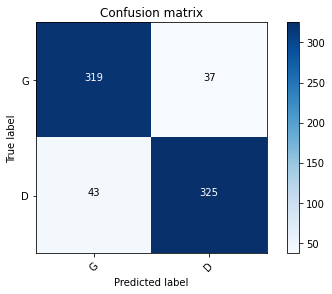

(0.88, 0.8995499643543763, 0.8650075053292963, 0.8798568156632566)

In [29]:
evaluate(RandomForest, X_train, y_train, X_test, y_test, args=[10, 150], plot_confusion=True)

  Accuracy  : 0.90207
  Precision : 0.90485
  Recall    : 0.88879
  F1        : 0.89533
Confusion matrix, without normalization
[[327  35]
 [ 35 327]]


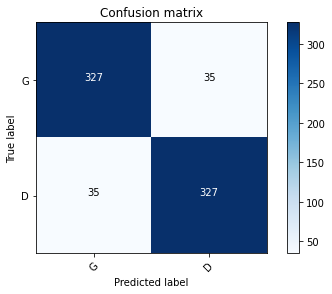

(0.9020689655172414,
 0.9048480162047683,
 0.8887890836868637,
 0.8953268709266567)

In [30]:
evaluate(RandomForest, X_train, y_train, X_test, y_test, args=[5, 200], plot_confusion=True)

# Save model

Before you go, we must write some functions to save and load the models for later use or for web deployment.

Note that Class DTNode, DecisionTree, Bagging, RandomForest must be defined in the same space where 'load_model' is called for the model to be loaded properly.

In [ ]:
import pickle

def save_model(obj, file_path):
    """
    Save an object to a file using pickle.

    Parameters:
    obj (object): The object to be saved.
    file_path (str): The path to the file where the object will be saved.
    """
    try:
        with open(file_path, 'wb') as file:
            pickle.dump(obj, file)
        print("Object saved successfully.")
    except Exception as e:
        print(f"Error occurred while saving the object: {str(e)}")

def load_model(file_path):
    """
    Load an object from a file using pickle.

    Parameters:
    file_path (str): The path to the file containing the object.

    Returns:
    object: The loaded object.
    """
    try:
        with open(file_path, 'rb') as file:
            obj = pickle.load(file)
        print("Object loaded successfully.")
        return obj
    except Exception as e:
        print(f"Error occurred while loading the object: {str(e)}")
        return None


In [ ]:
# Train and save model
rf_clf = RandomForest(num_trees=5, num_features=200)
rf_clf.fit(X_train, y_train)

save_model(rf_clf, 'randomforest.pkl')

Object saved successfully.


In [ ]:
# Load model 
clf = load_model('randomforest.pkl')

id = 9

print('(Graduated: 1.0, Dropout: -1.0)')
print('- Prediction :', clf.predict(X_test[id,:].reshape(1,-1))[0][0])
print('- Actual     :', y_test[id][0])

Object loaded successfully.
(Graduated: 1.0, Dropout: -1.0)
- Prediction : -1.0
- Actual     : -1.0
